<a href="https://colab.research.google.com/github/Jaskirat1/RNN/blob/main/sin_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
x = np.linspace(1, 50, 501)

In [59]:
y = np.sin(x)

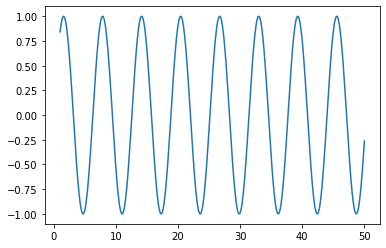

In [60]:
plt.plot(x, y)

In [61]:
df = pd.DataFrame(y, index = x, columns=['Sine'])
df

,Sine
1.000,0.841471
1.098,0.890298
1.196,0.930582
1.294,0.961936
1.392,0.984058
...,...
49.608,-0.611126
49.706,-0.530748
49.804,-0.445276
49.902,-0.355531


In [62]:
len(df)

501

In [63]:
test_percentage = 0.2

In [64]:
train_df = df.iloc[:400]
test_df = df.iloc[400:]

In [65]:
train_df.head()

,Sine
1.000,0.841471
1.098,0.890298
1.196,0.930582
1.294,0.961936
1.392,0.984058


In [66]:
test_df.head()

,Sine
40.200,0.597760
40.298,0.516454
40.396,0.430191
40.494,0.339800
40.592,0.246149


In [67]:
from sklearn.preprocessing import MinMaxScaler

In [68]:
scaler = MinMaxScaler()

In [69]:
scaler.fit(train_df)

MinMaxScaler()

In [70]:
train = scaler.transform(train_df)
test = scaler.transform(test_df)

In [71]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [72]:
generator = TimeseriesGenerator(train, train, length = 2, batch_size=1 )

In [73]:
generator[0]

(array([[[0.92074163],
         [0.9451555 ]]]), array([[0.96529754]]))

In [74]:
generator[1]

(array([[[0.9451555 ],
         [0.96529754]]]), array([[0.98097448]]))

In [75]:
generator = TimeseriesGenerator(train, train, length = 50 , batch_size = 1)

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [77]:
length = 50 
n_features = 1

In [78]:
model = Sequential()

model.add(SimpleRNN(50, input_shape = (50,1)))
model.add(Dense(1))

model.compile(optimizer ='adam', loss = 'mse')

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.fit(generator, epochs = 5)

Epoch 1/5
350/350 [==============================] - 4s 9ms/step - loss: 0.0029
Epoch 2/5
350/350 [==============================] - 3s 9ms/step - loss: 4.2466e-04
Epoch 3/5
350/350 [==============================] - 3s 9ms/step - loss: 1.7441e-05
Epoch 4/5
350/350 [==============================] - 3s 9ms/step - loss: 3.9202e-05
Epoch 5/5
350/350 [==============================] - 3s 9ms/step - loss: 1.8944e-04


In [81]:
loss_df = pd.DataFrame(model.history.history)

In [82]:
loss_df.head()

,loss
0,0.002907
1,0.000425
2,0.000017
3,0.000039
4,0.000189


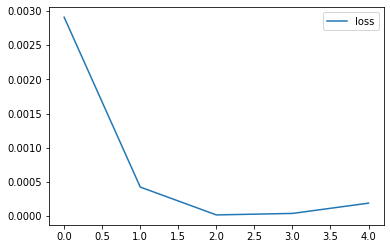

In [83]:
loss_df.plot()

In [84]:
first_batch = train[-50:]

In [85]:
first_batch.shape

(50, 1)

In [86]:
first_batch = first_batch.reshape(1, length , n_features)

In [87]:
first_batch.shape

(1, 50, 1)

In [88]:
model.predict(first_batch)

1/1 [==============================] - 0s 171ms/step


array([[0.79987633]], dtype=float32)

In [89]:
len(test)

101

In [90]:
test_predictions = []

first_batch = train[-length:]
current_batch = first_batch.reshape(1, length, n_features)

for i in range(len(test)):
  current_prediction = model.predict(current_batch)[0]
  test_predictions.append(current_prediction)
  current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 27ms/step


In [91]:
len(test_predictions)

101

In [92]:
true_predictions = scaler.inverse_transform(test_predictions)

In [93]:
test_df.head()

,Sine
40.200,0.597760
40.298,0.516454
40.396,0.430191
40.494,0.339800
40.592,0.246149


In [94]:
test_df['RNN Predcitions'] = true_predictions

<ipython-input-94-0b687a27b1e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['RNN Predcitions'] = true_predictions


In [95]:
test_df.head()

,Sine,RNN Predcitions
40.200,0.597760,0.599742
40.298,0.516454,0.518976
40.396,0.430191,0.433255
40.494,0.339800,0.342720
40.592,0.246149,0.248600


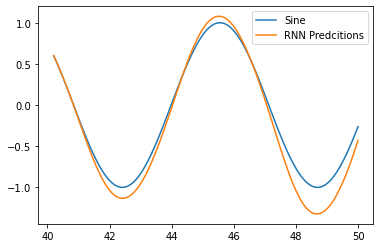

In [96]:
test_df.plot()

In [97]:
from tensorflow.keras.layers import LSTM

In [98]:
from tensorflow.keras.callbacks import EarlyStopping

In [99]:
early_stop = EarlyStopping(patience= 2)

In [100]:
length = 40

generator = TimeseriesGenerator(train, train, length=length, batch_size=1)

test_generator = TimeseriesGenerator(test, test, length=length, batch_size=1)

In [101]:
model = Sequential()

model.add(LSTM(50, input_shape=(length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


In [102]:
model.fit(generator, epochs = 30, validation_data = test_generator, callbacks =[early_stop])

Epoch 1/30
360/360 [==============================] - 9s 20ms/step - loss: 0.0171 - val_loss: 8.7176e-05
Epoch 2/30
360/360 [==============================] - 7s 19ms/step - loss: 6.6367e-05 - val_loss: 3.2360e-04
Epoch 3/30
360/360 [==============================] - 7s 19ms/step - loss: 9.2713e-05 - val_loss: 4.5712e-05
Epoch 4/30
360/360 [==============================] - 7s 19ms/step - loss: 2.9071e-04 - val_loss: 2.3141e-05
Epoch 5/30
360/360 [==============================] - 7s 20ms/step - loss: 7.4323e-05 - val_loss: 6.8716e-05
Epoch 6/30
360/360 [==============================] - 7s 19ms/step - loss: 1.6578e-04 - val_loss: 1.5804e-05
Epoch 7/30
360/360 [==============================] - 7s 18ms/step - loss: 1.3834e-04 - val_loss: 5.4497e-05
Epoch 8/30
360/360 [==============================] - 7s 18ms/step - loss: 7.1604e-05 - val_loss: 3.7518e-05


In [103]:
test_predictions = []


first_batch = train[-length:]
current_batch = first_batch.reshape(1, length, 1)


for i in range(len(test)):
  current_prediction = model.predict(current_batch)[0]
  test_predictions.append(current_prediction)
  current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 28ms/step


In [104]:
true_predictions = scaler.inverse_transform(test_predictions)

In [105]:
test_df['LSTM Predictions'] = true_predictions

<ipython-input-105-c41e70209db9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['LSTM Predictions'] = true_predictions


In [106]:
test_df.head()

,Sine,RNN Predcitions,LSTM Predictions
40.200,0.597760,0.599742,0.616616
40.298,0.516454,0.518976,0.538792
40.396,0.430191,0.433255,0.456537
40.494,0.339800,0.342720,0.370396
40.592,0.246149,0.248600,0.281025


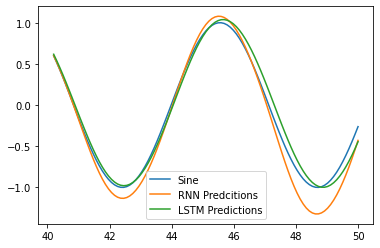

In [107]:
test_df.plot()